In [1]:
import random
import os
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.sparse import hstack
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from scipy.sparse import coo_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from itertools import product

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
random.seed(45)
os.chdir("/content/drive/MyDrive/2024/NLP/LSTM/data")
train=pd.read_csv("preprocessed_data_feb2.csv")
train.head(1)

,teacher_prefix,school_state,project_grade_category,clean_categories,clean_subcategories,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,essay,price,quantity
0,mrs,in,grades_prek_2,literacy_language,esl_literacy,educational support english learners home,My students need opportunities to practice beg...,0,0,students english learners working english seco...,-0.390533,23


In [3]:
#splitting data into train test valid
X=train.drop("project_is_approved" , axis=1)
Y=train["project_is_approved"]

X_train , X_val  , y_train , y_val = train_test_split(X , Y , test_size=0.30 , stratify=Y)
X_val ,X_test,y_val ,y_test= train_test_split(X_val , y_val , test_size=0.30 , stratify=y_val)

print(X_train.shape , y_train.shape)
print(X_val.shape , y_val.shape)
print(X_test.shape , y_test.shape )

(76473, 11) (76473,)
(22942, 11) (22942,)
(9833, 11) (9833,)


In [4]:
# Essay text to tfidf
tfidf_vectorizer = TfidfVectorizer(min_df =20 ,max_features=5000)
X_train_tfidf_essay = tfidf_vectorizer.fit_transform(X_train["essay"])
X_val_tfidf_essay = tfidf_vectorizer.transform(X_val["essay"])
X_test_tfidf_essay = tfidf_vectorizer.transform(X_test["essay"])

In [5]:
#label calsses to one hot encoding
label_encoder = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), ['teacher_prefix', 'school_state', 'project_grade_category'])
    ],
    remainder='passthrough'
)

X_train_labels = label_encoder.fit_transform(X_train[['teacher_prefix', 'school_state', 'project_grade_category']])
X_val_labels = label_encoder.transform(X_val[['teacher_prefix', 'school_state', 'project_grade_category']])
X_test_labels = label_encoder.transform(X_test[['teacher_prefix', 'school_state', 'project_grade_category']])

In [6]:
X_train_labels.toarray()[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [7]:
print(X_train.columns)

Index(['teacher_prefix', 'school_state', 'project_grade_category',
       'clean_categories', 'clean_subcategories', 'project_title',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'essay', 'price',
       'quantity'],
      dtype='object')


In [8]:
# Convert the clean_subcategories to a list of strings
X_train['clean_subcategories'] = X_train['clean_subcategories'].apply(lambda x: [x])
X_test['clean_subcategories'] = X_test['clean_subcategories'].apply(lambda x: [x])
X_val['clean_subcategories'] = X_val['clean_subcategories'].apply(lambda x: [x])

# Feature Hashing for 'clean_subcategories'
hasher = FeatureHasher(n_features=100, input_type="string", alternate_sign=False)
X_train_clean_subcategories_hashed = hasher.fit_transform(X_train['clean_subcategories'])
X_val_clean_subcategories_hashed = hasher.transform(X_val['clean_subcategories'])
X_test_clean_subcategories_hashed = hasher.transform(X_test['clean_subcategories'])

# Convert the string column to a list of strings
X_train['clean_categories'] = X_train['clean_categories'].apply(lambda x: [x])
X_val['clean_categories'] = X_val['clean_categories'].apply(lambda x: [x])
X_test['clean_categories'] = X_test['clean_categories'].apply(lambda x: [x])

# Feature Hashing for 'clean_categories'
hasher = FeatureHasher(n_features=100, input_type="string", alternate_sign=False)
X_train_clean_categories_hashed = hasher.fit_transform(X_train['clean_categories'])
X_val_clean_categories_hashed = hasher.transform(X_val['clean_categories'])
X_test_clean_categories_hashed = hasher.transform(X_test['clean_categories'])

In [9]:
X_train_price = X_train[['price']]
X_val_price = X_val[['price']]
X_test_price =X_test[['price']]

X_train_prev_posted_proj = X_train[['teacher_number_of_previously_posted_projects']]
X_val_prev_posted_proj  = X_val[['teacher_number_of_previously_posted_projects']]
X_test_prev_posted_proj  = X_test[['teacher_number_of_previously_posted_projects']]

In [10]:
# Concatenate features
X_train_combined = hstack([X_train_tfidf_essay, X_train_labels,X_train_clean_categories_hashed ,X_train_clean_subcategories_hashed , X_train_price,X_train_prev_posted_proj])
X_val_combined = hstack([X_val_tfidf_essay,X_val_labels,X_val_clean_categories_hashed,X_val_clean_subcategories_hashed ,X_val_price ,X_val_prev_posted_proj ])
X_test_combined = hstack([X_test_tfidf_essay, X_test_labels,X_test_clean_categories_hashed ,X_test_clean_subcategories_hashed  , X_test_price,X_test_prev_posted_proj])

X_train_combined.shape , X_val_combined.shape , X_test_combined.shape

((76473, 5262), (22942, 5262), (9833, 5262))

In [11]:
#normalize all Features
scaler = StandardScaler(with_mean=False)

X_train_combined_scaled = scaler.fit_transform(X_train_combined)
X_test_combined_scaled = scaler.transform(X_test_combined)
X_val_combined_scaled = scaler.transform(X_val_combined)

In [15]:
def evaluation_matrix(model , X_test ,y_test):
  # Calculate evaluation metrics
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])  # Assuming binary classification

  # Confusion Matrix
  conf_matrix = confusion_matrix(y_test, y_pred)
  # Print the metrics
  print("accuracy: ", accuracy)
  print("Precision: ", precision)
  print("Recall: ", recall)
  print("F1 Score: ", f1)
  print("ROC AUC: ", roc_auc)
  print("Confusion Matrix: ")

  plt.figure(figsize=(4, 3))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
              xticklabels=['Predicted 0', 'Predicted 1'],
              yticklabels=['Actual 0', 'Actual 1'])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()

Logistic Regression

>without essay

>with essay

accuracy:  0.848266042916709
Precision:  0.8485958485958486
Recall:  0.9995206136145733
F1 Score:  0.9178956636583754
ROC AUC:  0.5901204148414676
Confusion Matrix: 


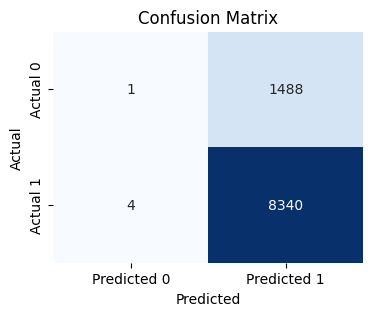

In [14]:
#training logistic regression model without tfidf Essay
X_train_combined = hstack([ X_train_labels,X_train_clean_categories_hashed ,X_train_clean_subcategories_hashed, X_train_price,X_train_prev_posted_proj])
X_val_combined = hstack([X_val_labels,X_val_clean_categories_hashed,X_val_clean_subcategories_hashed,X_val_price ,X_val_prev_posted_proj ])
X_test_combined = hstack([X_test_labels,X_test_clean_categories_hashed ,X_test_clean_subcategories_hashed , X_test_price,X_test_prev_posted_proj])

scaler = StandardScaler(with_mean=False)

X_train_combined_scaled = scaler.fit_transform(X_train_combined)
X_test_combined_scaled = scaler.transform(X_test_combined)
X_val_combined_scaled = scaler.transform(X_val_combined)

# Logistic Regression model
logreg = LogisticRegression(max_iter=1000, solver='sag')
logreg.fit(X_train_combined_scaled, y_train)

# Evaluate the model
evaluation_matrix(logreg , X_test_combined_scaled  ,y_test)

In [ ]:
#lists of hyperparameter values to try
penalty_values = [ 'l2']
c_values = [1.0, 0.1, 0.01, 0.001]
max_iter_values = [1000, 500, 200]
solver_values = ['liblinear', 'saga']
class_weight_values = [None, 'balanced']

# Iterating over hyperparameters
for penalty, c, max_iter, solver, class_weight in product(penalty_values, c_values, max_iter_values, solver_values, class_weight_values):
    # Logistic Regression model
    logreg = LogisticRegression(
        penalty=penalty,C=c,max_iter=max_iter,solver=solver,class_weight=class_weight,random_state=42
    )
    logreg.fit(X_train_combined_scaled, y_train)

    # Evaluate the model
    print(f"Metrics for hyperparameters: penalty={penalty}, C={c}, max_iter={max_iter}, solver={solver}, class_weight={class_weight}")
    evaluation_matrix(logreg, X_test_combined_scaled, y_test)

accuracy:  0.8396216820909184
Precision:  0.8644049542272483
Recall:  0.961888782358581
F1 Score:  0.9105451245107492
ROC AUC:  0.7015167798112976
Confusion Matrix: 


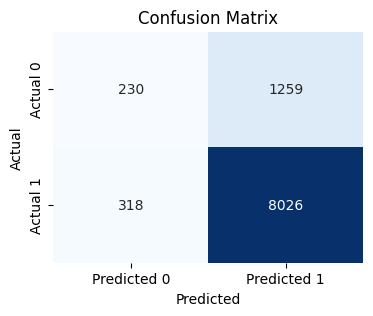

In [17]:
#ran modle training with various combination of hyperparam
#got best hyperparam combination to train on

X_train_combined = hstack([X_train_tfidf_essay, X_train_labels,X_train_clean_categories_hashed ,X_train_clean_subcategories_hashed , X_train_price,X_train_prev_posted_proj])
X_val_combined = hstack([X_val_tfidf_essay,X_val_labels,X_val_clean_categories_hashed,X_val_clean_subcategories_hashed ,X_val_price ,X_val_prev_posted_proj ])
X_test_combined = hstack([X_test_tfidf_essay, X_test_labels,X_test_clean_categories_hashed ,X_test_clean_subcategories_hashed  , X_test_price,X_test_prev_posted_proj])

scaler = StandardScaler(with_mean=False)

X_train_combined_scaled = scaler.fit_transform(X_train_combined)
X_test_combined_scaled = scaler.transform(X_test_combined)
X_val_combined_scaled = scaler.transform(X_val_combined)

# Logistic Regression model using Essay++
logreg = LogisticRegression(
    penalty='l2',
    C=0.1,
    max_iter=1000,
    solver='sag',
    class_weight=None,
    random_state=42
)
logreg.fit(X_train_combined_scaled, y_train)

# Evaluate the model
evaluation_matrix(logreg , X_test_combined_scaled  ,y_test)

SVM

In [15]:
#slicing subset of rows
subset_fraction = 0.4
X_train_csr = X_train_combined.tocsr()

# Get the number of rows
num_rows = X_train_csr.shape[0]
subset_size = int(num_rows * subset_fraction)

X_train_subset = X_train_csr[:subset_size, :]
y_train_subset = y_train[:subset_size]

In [16]:
# SVM model
svm_model = SVC(kernel='linear' , verbose =True)
svm_model.fit(X_train_subset, y_train_subset)

# Evaluate the model
evaluation_matrix(logreg , X_test_combined  ,y_test)

[LibSVM]SVM Accuracy: 0.8485746665504316


Decision Tree Classifier
> first running DT with various hyperparam and training final model with Best hyerparam

Metrics for hyperparameters: max_depth=None, min_samples_split=2, min_samples_leaf=1
accuracy:  0.7601952608563002
Precision:  0.860950313555234
Recall:  0.8555848513902206
F1 Score:  0.8582591969223371
ROC AUC:  0.7015167798112976
Confusion Matrix: 


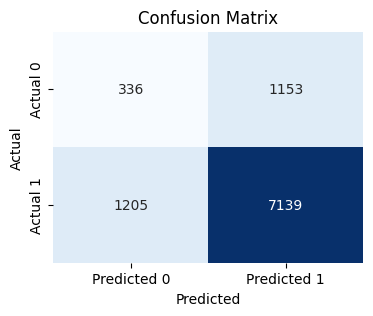



Metrics for hyperparameters: max_depth=None, min_samples_split=2, min_samples_leaf=2
accuracy:  0.7571443099766094
Precision:  0.8621108949416343
Recall:  0.849712368168744
F1 Score:  0.8558667310478031
ROC AUC:  0.7015167798112976
Confusion Matrix: 


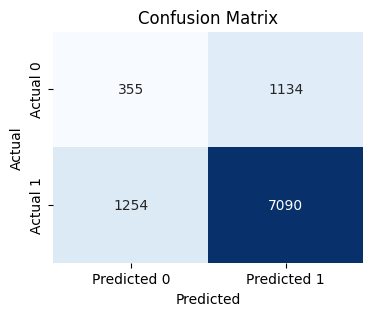



Metrics for hyperparameters: max_depth=None, min_samples_split=2, min_samples_leaf=4
accuracy:  0.7546018509102004
Precision:  0.8612498477281033
Recall:  0.8473154362416108
F1 Score:  0.8542258200930345
ROC AUC:  0.7015167798112976
Confusion Matrix: 


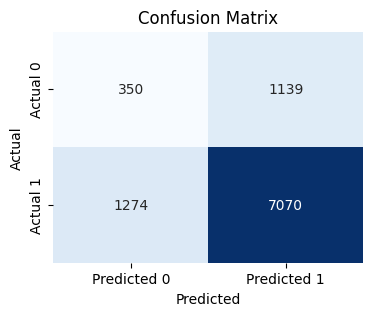



Metrics for hyperparameters: max_depth=None, min_samples_split=5, min_samples_leaf=1
accuracy:  0.7536865656462931
Precision:  0.8596938775510204
Recall:  0.8481543624161074
F1 Score:  0.8538851351351352
ROC AUC:  0.7015167798112976
Confusion Matrix: 


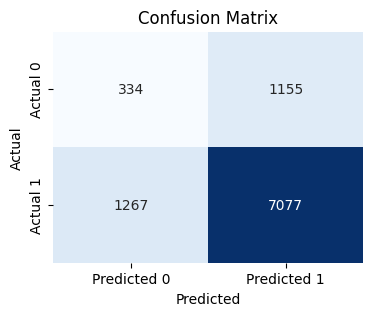



Metrics for hyperparameters: max_depth=None, min_samples_split=5, min_samples_leaf=2
accuracy:  0.7474829655242551
Precision:  0.859438243591316
Recall:  0.839765100671141
F1 Score:  0.8494877856579983
ROC AUC:  0.7015167798112976
Confusion Matrix: 


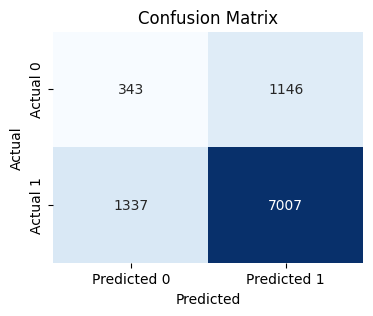



Metrics for hyperparameters: max_depth=None, min_samples_split=5, min_samples_leaf=4
accuracy:  0.7546018509102004
Precision:  0.8612498477281033
Recall:  0.8473154362416108
F1 Score:  0.8542258200930345
ROC AUC:  0.7015167798112976
Confusion Matrix: 


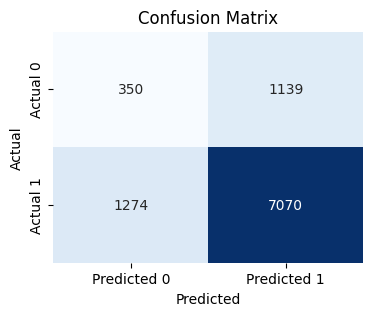



Metrics for hyperparameters: max_depth=None, min_samples_split=10, min_samples_leaf=1
accuracy:  0.7505339164039458
Precision:  0.8602176837470955
Recall:  0.8430009587727708
F1 Score:  0.8515223049452212
ROC AUC:  0.7015167798112976
Confusion Matrix: 


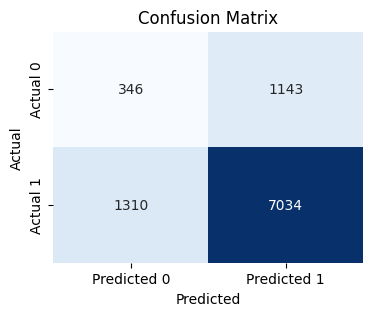



Metrics for hyperparameters: max_depth=None, min_samples_split=10, min_samples_leaf=2
accuracy:  0.749720329502695
Precision:  0.861496866166892
Recall:  0.840124640460211
F1 Score:  0.8506765366179238
ROC AUC:  0.7015167798112976
Confusion Matrix: 


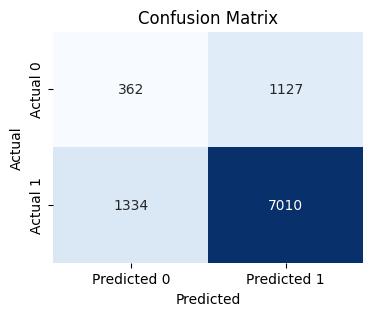



Metrics for hyperparameters: max_depth=None, min_samples_split=10, min_samples_leaf=4
accuracy:  0.756737516525984
Precision:  0.8599419448476052
Recall:  0.8521093000958773
F1 Score:  0.8560077052732963
ROC AUC:  0.7015167798112976
Confusion Matrix: 


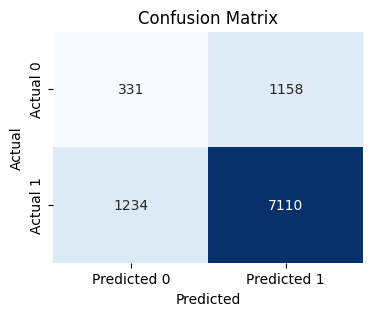



Metrics for hyperparameters: max_depth=10, min_samples_split=2, min_samples_leaf=1
accuracy:  0.8427743313332655
Precision:  0.8507016095749071
Recall:  0.9881351869606904
F1 Score:  0.9142825460190729
ROC AUC:  0.7015167798112976
Confusion Matrix: 


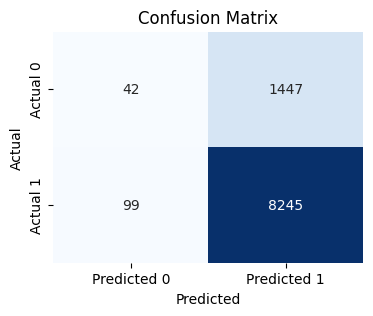



Metrics for hyperparameters: max_depth=10, min_samples_split=2, min_samples_leaf=2
accuracy:  0.8427743313332655
Precision:  0.8504846360074242
Recall:  0.9884947267497604
F1 Score:  0.9143110519898016
ROC AUC:  0.7015167798112976
Confusion Matrix: 


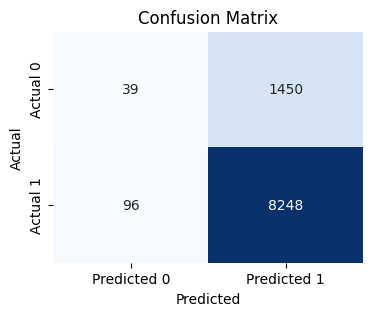



Metrics for hyperparameters: max_depth=10, min_samples_split=2, min_samples_leaf=4
accuracy:  0.8409437608054511
Precision:  0.8503513848697809
Recall:  0.986097794822627
F1 Score:  0.9132075471698112
ROC AUC:  0.7015167798112976
Confusion Matrix: 


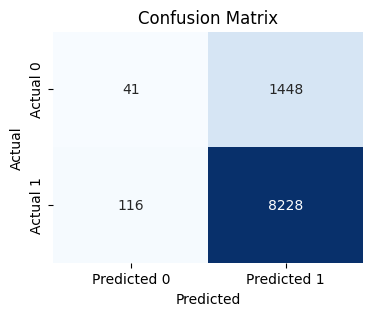



Metrics for hyperparameters: max_depth=10, min_samples_split=5, min_samples_leaf=1
accuracy:  0.8428760296959219
Precision:  0.8505723419614314
Recall:  0.9884947267497604
F1 Score:  0.9143617316113297
ROC AUC:  0.7015167798112976
Confusion Matrix: 


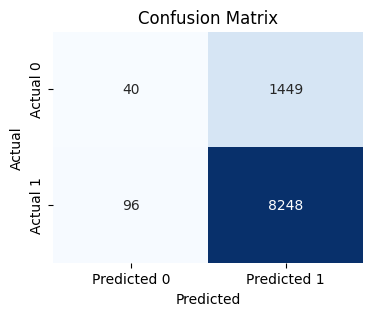



Metrics for hyperparameters: max_depth=10, min_samples_split=5, min_samples_leaf=2
accuracy:  0.8429777280585783
Precision:  0.8507324118011141
Recall:  0.9883748801534037
F1 Score:  0.9144029271537866
ROC AUC:  0.7015167798112976
Confusion Matrix: 


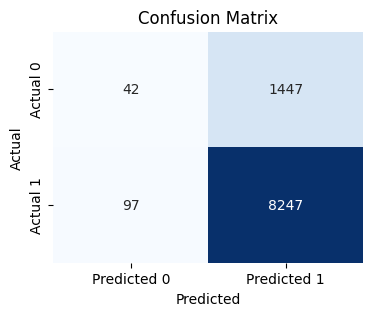



Metrics for hyperparameters: max_depth=10, min_samples_split=5, min_samples_leaf=4
accuracy:  0.8409437608054511
Precision:  0.8503513848697809
Recall:  0.986097794822627
F1 Score:  0.9132075471698112
ROC AUC:  0.7015167798112976
Confusion Matrix: 


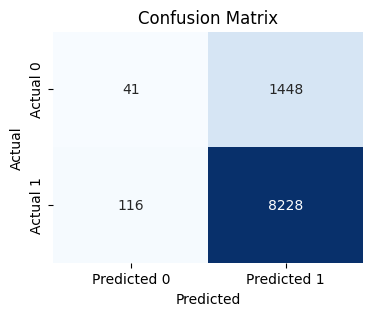



Metrics for hyperparameters: max_depth=10, min_samples_split=10, min_samples_leaf=1
accuracy:  0.8427743313332655
Precision:  0.8506292552094079
Recall:  0.988255033557047
F1 Score:  0.9142920501164209
ROC AUC:  0.7015167798112976
Confusion Matrix: 


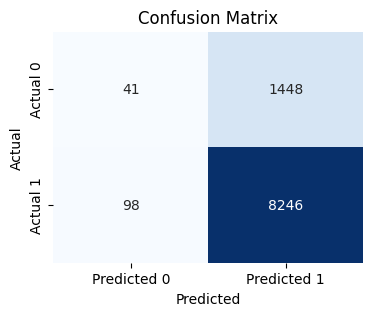



Metrics for hyperparameters: max_depth=10, min_samples_split=10, min_samples_leaf=2
accuracy:  0.8426726329706091
Precision:  0.8506138450428145
Recall:  0.9881351869606904
F1 Score:  0.9142318567389257
ROC AUC:  0.7015167798112976
Confusion Matrix: 


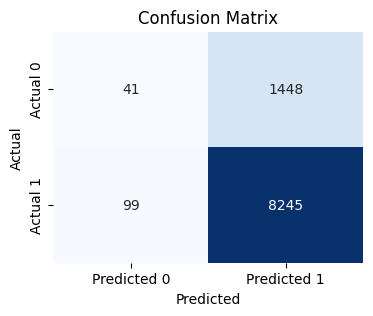



Metrics for hyperparameters: max_depth=10, min_samples_split=10, min_samples_leaf=4
accuracy:  0.8418590460693582
Precision:  0.8506352649519677
Recall:  0.9869367209971237
F1 Score:  0.9137309292649098
ROC AUC:  0.7015167798112976
Confusion Matrix: 


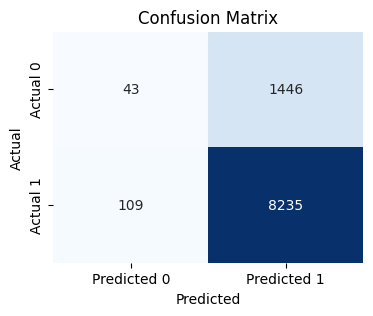



Metrics for hyperparameters: max_depth=20, min_samples_split=2, min_samples_leaf=1
accuracy:  0.8286382589240313
Precision:  0.8565920531219878
Recall:  0.9585330776605945
F1 Score:  0.9046999604094792
ROC AUC:  0.7015167798112976
Confusion Matrix: 


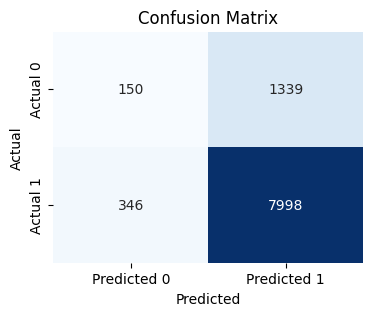



Metrics for hyperparameters: max_depth=20, min_samples_split=2, min_samples_leaf=2
accuracy:  0.8286382589240313
Precision:  0.8572041626434932
Recall:  0.9575743048897412
F1 Score:  0.9046136427964903
ROC AUC:  0.7015167798112976
Confusion Matrix: 


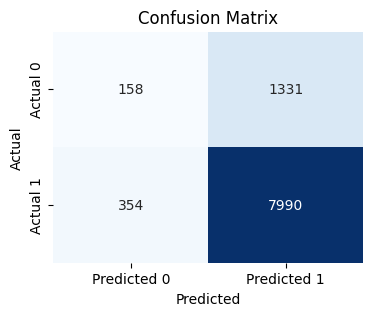



Metrics for hyperparameters: max_depth=20, min_samples_split=2, min_samples_leaf=4
accuracy:  0.8248754195057459
Precision:  0.8560980856098086
Recall:  0.9539789069990412
F1 Score:  0.9023920190454597
ROC AUC:  0.7015167798112976
Confusion Matrix: 


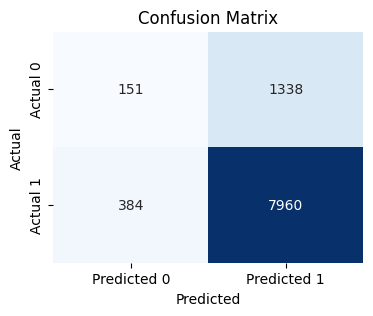



Metrics for hyperparameters: max_depth=20, min_samples_split=5, min_samples_leaf=1
accuracy:  0.8300620360012204
Precision:  0.8561212509339311
Recall:  0.9612895493767977
F1 Score:  0.9056625077626602
ROC AUC:  0.7015167798112976
Confusion Matrix: 


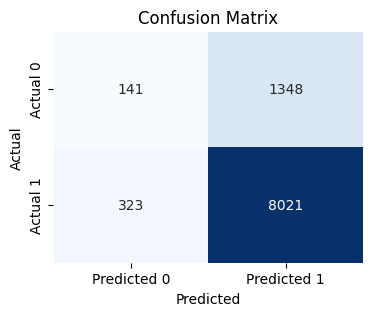



Metrics for hyperparameters: max_depth=20, min_samples_split=5, min_samples_leaf=2
accuracy:  0.8285365605613749
Precision:  0.856271404109589
Recall:  0.9588926174496645
F1 Score:  0.9046811397557667
ROC AUC:  0.7015167798112976
Confusion Matrix: 


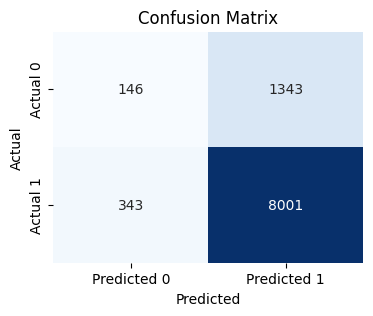



Metrics for hyperparameters: max_depth=20, min_samples_split=5, min_samples_leaf=4
accuracy:  0.8248754195057459
Precision:  0.8560980856098086
Recall:  0.9539789069990412
F1 Score:  0.9023920190454597
ROC AUC:  0.7015167798112976
Confusion Matrix: 


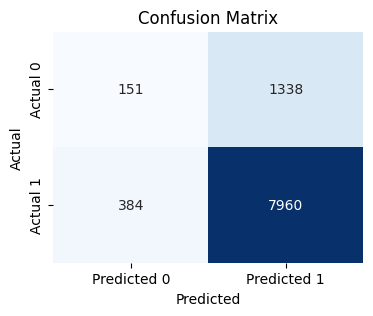



Metrics for hyperparameters: max_depth=20, min_samples_split=10, min_samples_leaf=1
accuracy:  0.8280280687480932
Precision:  0.8560419565450069
Recall:  0.9585330776605945
F1 Score:  0.9043930570475489
ROC AUC:  0.7015167798112976
Confusion Matrix: 


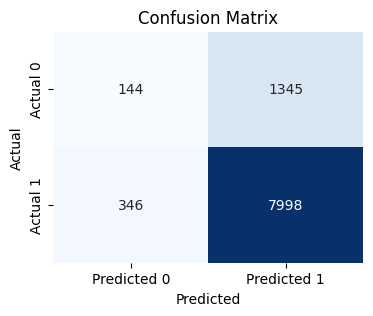



Metrics for hyperparameters: max_depth=20, min_samples_split=10, min_samples_leaf=2
accuracy:  0.8288416556493441
Precision:  0.8574648492003863
Recall:  0.9574544582933845
F1 Score:  0.904705282826567
ROC AUC:  0.7015167798112976
Confusion Matrix: 


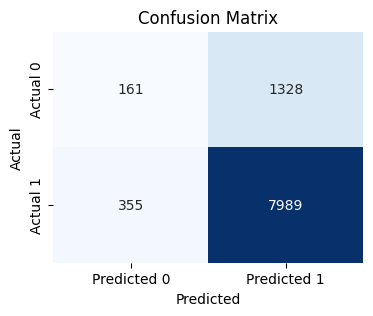



Metrics for hyperparameters: max_depth=20, min_samples_split=10, min_samples_leaf=4
accuracy:  0.8244686260551205
Precision:  0.8554242749731471
Recall:  0.9544582933844679
F1 Score:  0.902231788829727
ROC AUC:  0.7015167798112976
Confusion Matrix: 


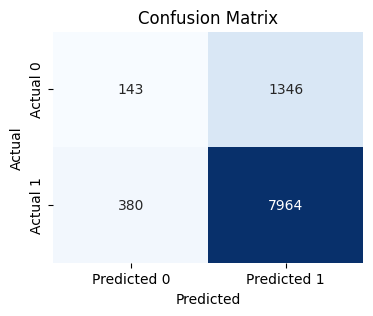



Metrics for hyperparameters: max_depth=30, min_samples_split=2, min_samples_leaf=1
accuracy:  0.8133835045255772
Precision:  0.8588598522439078
Recall:  0.9334851390220518
F1 Score:  0.8946189628438523
ROC AUC:  0.7015167798112976
Confusion Matrix: 


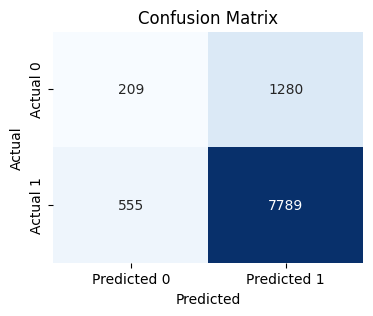



Metrics for hyperparameters: max_depth=30, min_samples_split=2, min_samples_leaf=2
accuracy:  0.8133835045255772
Precision:  0.8602102933038185
Recall:  0.9314477468839885
F1 Score:  0.8944127970539156
ROC AUC:  0.7015167798112976
Confusion Matrix: 


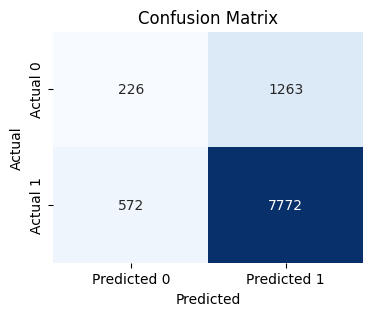



Metrics for hyperparameters: max_depth=30, min_samples_split=2, min_samples_leaf=4
accuracy:  0.8088070782060409
Precision:  0.8587921847246892
Recall:  0.9271332694151486
F1 Score:  0.8916551406177962
ROC AUC:  0.7015167798112976
Confusion Matrix: 


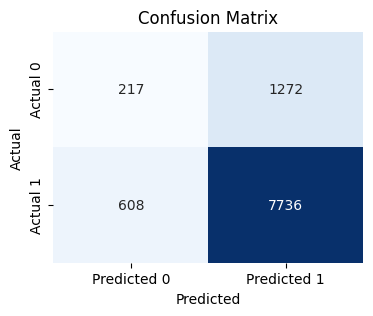



Metrics for hyperparameters: max_depth=30, min_samples_split=5, min_samples_leaf=1
accuracy:  0.8135869012508898
Precision:  0.8580226547893984
Recall:  0.9350431447746884
F1 Score:  0.894878706199461
ROC AUC:  0.7015167798112976
Confusion Matrix: 


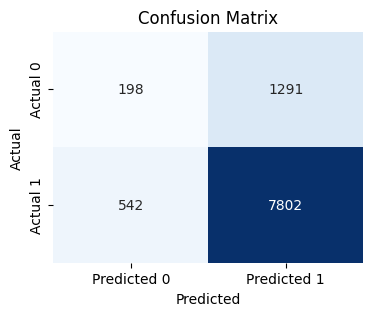



Metrics for hyperparameters: max_depth=30, min_samples_split=5, min_samples_leaf=2
accuracy:  0.8119597274483881
Precision:  0.8584041496523562
Recall:  0.9321668264621285
F1 Score:  0.8937661591496697
ROC AUC:  0.7015167798112976
Confusion Matrix: 


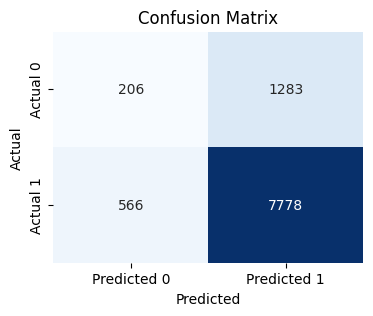



Metrics for hyperparameters: max_depth=30, min_samples_split=5, min_samples_leaf=4
accuracy:  0.8088070782060409
Precision:  0.8587921847246892
Recall:  0.9271332694151486
F1 Score:  0.8916551406177962
ROC AUC:  0.7015167798112976
Confusion Matrix: 


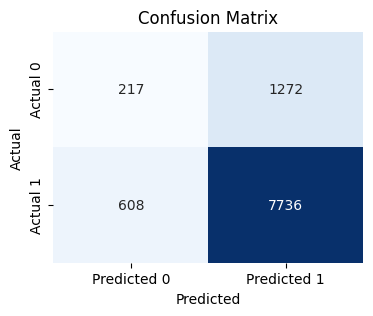



Metrics for hyperparameters: max_depth=30, min_samples_split=10, min_samples_leaf=1
accuracy:  0.8110444421844808
Precision:  0.8587389380530973
Recall:  0.9303691275167785
F1 Score:  0.8931201104463874
ROC AUC:  0.7015167798112976
Confusion Matrix: 


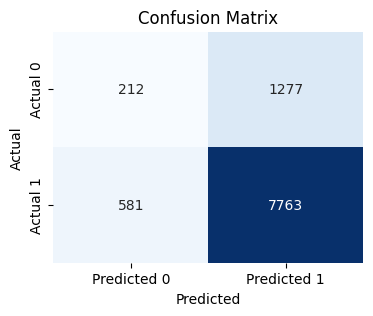



Metrics for hyperparameters: max_depth=30, min_samples_split=10, min_samples_leaf=2
accuracy:  0.8077900945794773
Precision:  0.8574435090828534
Recall:  0.927732502396932
F1 Score:  0.8912042367027401
ROC AUC:  0.7015167798112976
Confusion Matrix: 


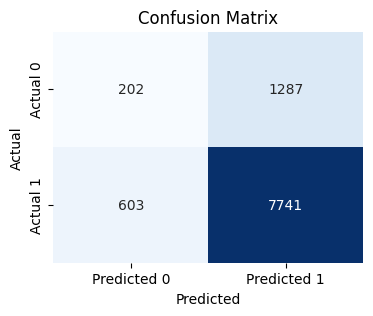



Metrics for hyperparameters: max_depth=30, min_samples_split=10, min_samples_leaf=4
accuracy:  0.8072816027661954
Precision:  0.8579198579198579
Recall:  0.926294343240652
F1 Score:  0.8907969803492191
ROC AUC:  0.7015167798112976
Confusion Matrix: 


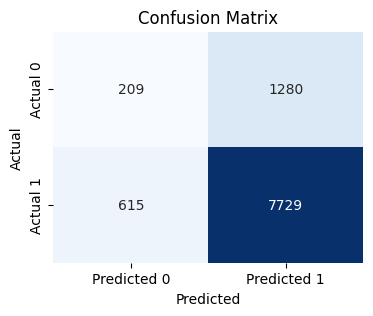

In [21]:
from sklearn.tree import DecisionTreeClassifier
from itertools import product

#lists of hyperparameter values to try
max_depth_values = [None, 10, 20, 30]
min_samples_split_values = [2, 5, 10]
min_samples_leaf_values = [1, 2, 4]

for max_depth, min_samples_split, min_samples_leaf in product(max_depth_values, min_samples_split_values, min_samples_leaf_values):

    DT = DecisionTreeClassifier(random_state=42,
        max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf
    )
    DT.fit(X_train_combined_scaled, y_train)
    # Evaluate the model
    print(f"Metrics for hyperparameters: max_depth={max_depth}, min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf}")
    evaluation_matrix(DT, X_test_combined_scaled, y_test)

In [ ]:
# best Metrics for hyperparameters: max_depth=None, min_samples_split=2, min_samples_leaf=1
# Decision Tree model

DT = DecisionTreeClassifier(random_state=42,
        max_depth=None, min_samples_split=2, min_samples_leaf=1
    )
DT.fit(X_train_combined_scaled, y_train)

accuracy:  0.7647716871758364
Precision:  0.8617876424715057
Recall:  0.8608581016299137
F1 Score:  0.8613226212602674
ROC AUC:  0.5436058098152834
Confusion Matrix: 


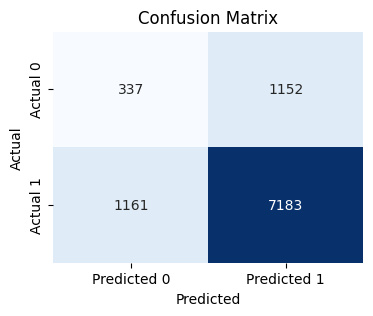

In [16]:
# Evaluate the model
evaluation_matrix(DT , X_test_combined_scaled ,y_test)

accuracy:  0.8477575511034272
Precision:  0.8488739427290329
Recall:  0.9983221476510067
F1 Score:  0.9175524591066806
ROC AUC:  0.7015167798112976
Confusion Matrix: 


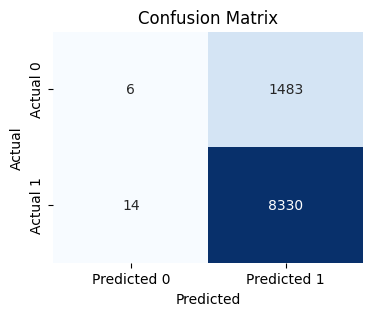

In [20]:
# Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_combined_scaled, y_train)

# Evaluate the model
evaluation_matrix(rf , X_test_combined_scaled  ,y_test)